In [70]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns


import pypsa_helpers as ph
import importlib

ph = importlib.reload(ph)


In [2]:
demand_nodes=pd.read_csv("../4_real_map_cleaned/demand_estimates.csv")
distrib_nodes = pd.read_csv("../4_real_map_cleaned/supply_estimates.csv")

In [3]:
demand_nodes=demand_nodes[["cluster_id","x_km_shift", "y_km_shift", 'scaled_demand']].iloc[:-1]
demand_nodes["cluster_id"] = demand_nodes["cluster_id"].astype(float).astype(int)
distrib_nodes=distrib_nodes[["node_id", "node_type", "x_km_shift", "y_km_shift", "scaled_supply"]]

In [23]:
demand_nodes["loc"] = list(zip(demand_nodes["x_km_shift"], demand_nodes["y_km_shift"]))
demand_nodes["load"] = demand_nodes["scaled_demand"]*6.2
demand_nodes["p_nom_combustion"] = 1000
demand_nodes["combustion_efficiency"]=0.22

distrib_nodes["loc"] = list(zip(distrib_nodes["x_km_shift"], distrib_nodes["y_km_shift"]))


In [75]:
zeros = n.lines.query("r == 0 and x == 0")
print("Zero-impedance lines:")
print(zeros[["bus0", "bus1", "length", "r", "x"]])

Zero-impedance lines:
Empty DataFrame
Columns: [bus0, bus1, length, r, x]
Index: []


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 364.53it/s]
INFO:linopy.io: Writing time: 0.2s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 30780 primals, 71100 duals
Objective: 1.28e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Running non-linear power flow iteratively...
INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001981AFC7CD0> for snapshots Index([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,
       ...
   

RuntimeError: failed to factorize matrix at line 406 in file ../scipy/sparse/linalg/_dsolve/SuperLU/SRC/dpanel_bmod.c


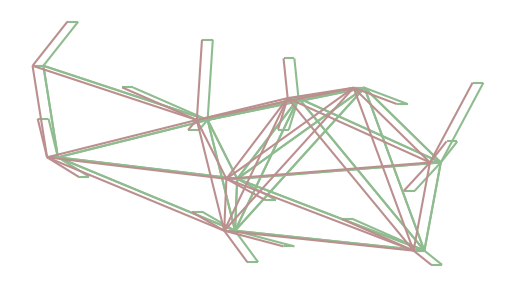

In [71]:
n=ph.build_network(distribution_nodes=distrib_nodes, load_nodes=demand_nodes, plotbool=True,link_radius2=4000000, supplyscale=48,time_varying=True,
                        num_days=30)

In [33]:
RTEs = [0.8]
df_fuel_favored=[]
for RTE in RTEs:
    alpha, n = ph.search_min_supplyscale_bisection(
                    build_network_fn=ph.build_network,
                    distribution_nodes=distrib_nodes,
                    load_nodes=demand_nodes,
                    alpha_low=47,      # something you suspect is too small
                    alpha_high=53,     # you know this works
                    tol=0.1,
                    max_iter=30,
                    verbose=True,
                    build_kwargs=dict(
                        plotbool=False,           # turn off plotting during search
                        link_radius2=4000000,
                        electric_line_loss_decay=1e-4,
                        fuel_line_loss_decay=5e-6,
                        electrolysis_efficiency=np.sqrt(RTE),
                        combustion_efficiency=np.sqrt(RTE),
                        time_varying=True,
                        num_days=30,
                    ),
                )
    print("Best alpha: ", alpha)
    
    df_fuel_favored.append({
        'network':n,
        'electric_decay':1e-4,
        'fuel_decay':5e-6,
        'RTE':RTE,
        'alpha':alpha,
        'fuel-km pct': ph.fuel_km_metrics(n)[1],
        'shortest-fuel-line': ph.min_fuel_transmission_distance(n)
    })
df_fuel_favored=pd.DataFrame(df_fuel_favored)
                    

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 298.68it/s]
INFO:linopy.io: Writing time: 0.18s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 30780 primals, 71100 duals
Objective: 9.38e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 492.50it/s]
INFO:linopy.io: Writing time: 0.18s
I

Minimum feasible supplyscale α* ≈ 47.0938
Best alpha:  47.09375


IndexError: invalid index to scalar variable.

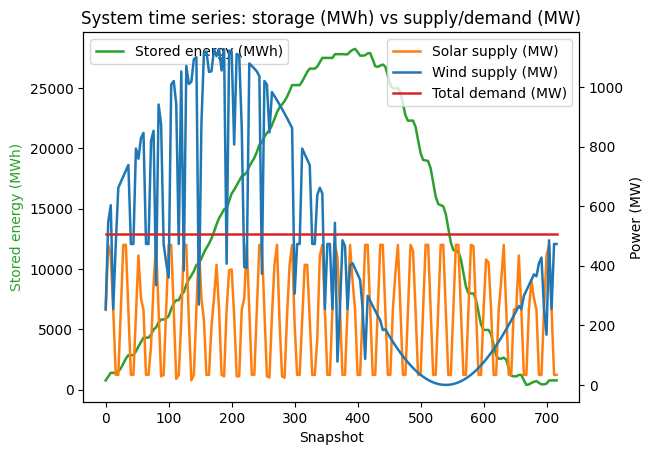

In [61]:
ph.plot_system_timeseries_dualaxis(n)

,p0,p1,bus0,bus1,length_km,p_sent,p_recv,efficiency,eff_per_km,decay_pct_per_km
name,,,,,,,,,,
12elec,2.567243,-2.567243,DNode1_Elec,DNode2_Elec,936.256788,2.567243,2.567243,1.0,1.0,0.0
13elec,10.608858,-10.608858,DNode1_Elec,DNode3_Elec,608.908757,10.608858,10.608858,1.0,1.0,0.0
23elec,8.041614,-8.041614,DNode2_Elec,DNode3_Elec,863.517980,8.041614,8.041614,1.0,1.0,0.0
34elec,-10.348957,10.348957,DNode3_Elec,DNode4_Elec,1598.411496,10.348957,10.348957,1.0,1.0,0.0
15elec,21.061960,-21.061960,DNode1_Elec,DNode5_Elec,1668.996787,21.061960,21.061960,1.0,1.0,0.0
35elec,10.453102,-10.453102,DNode3_Elec,DNode5_Elec,1426.070867,10.453102,10.453102,1.0,1.0,0.0
45elec,20.802059,-20.802059,DNode4_Elec,DNode5_Elec,856.713207,20.802059,20.802059,1.0,1.0,0.0
16elec,25.888186,-25.888186,DNode1_Elec,DNode6_Elec,479.904955,25.888186,25.888186,1.0,1.0,0.0
26elec,23.320942,-23.320942,DNode2_Elec,DNode6_Elec,1358.236891,23.320942,23.320942,1.0,1.0,0.0


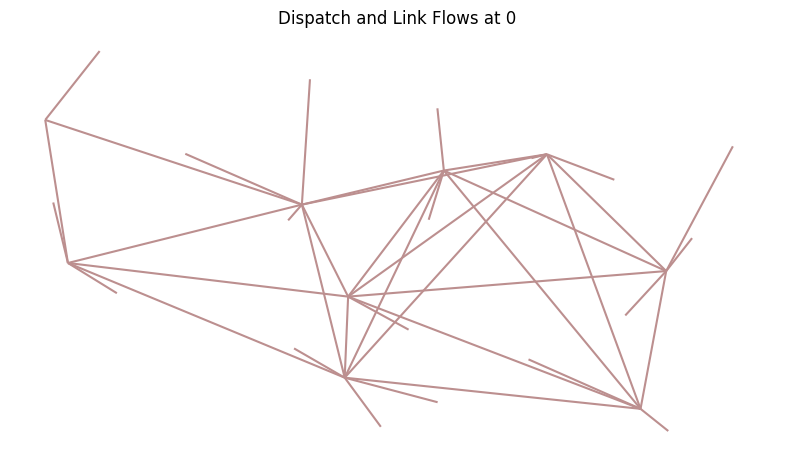

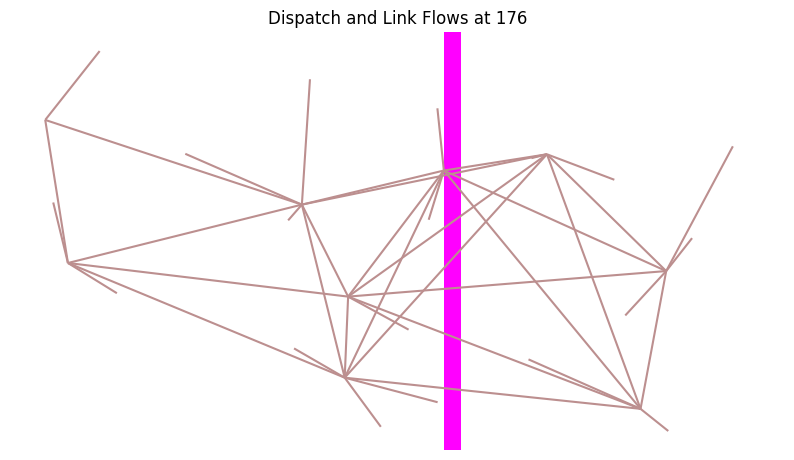

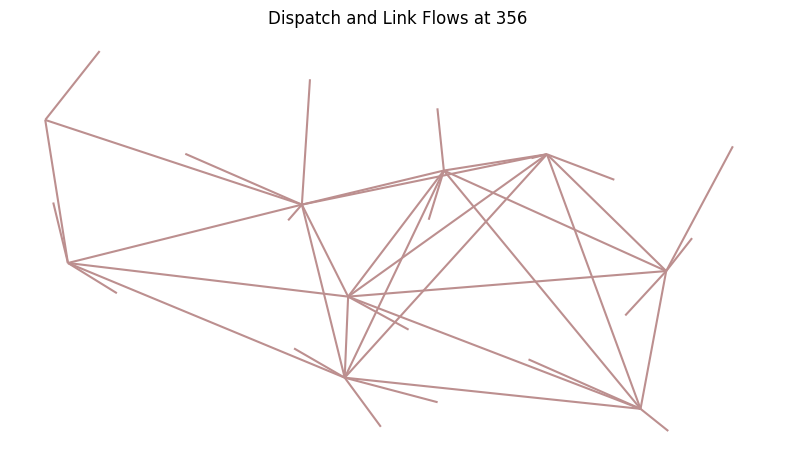

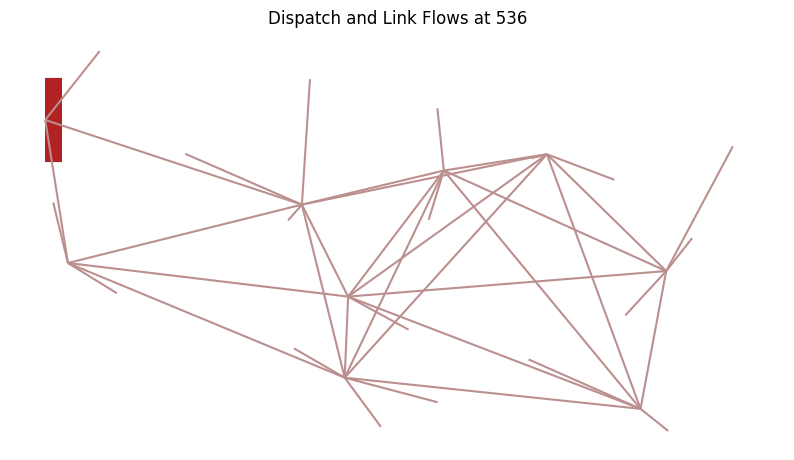

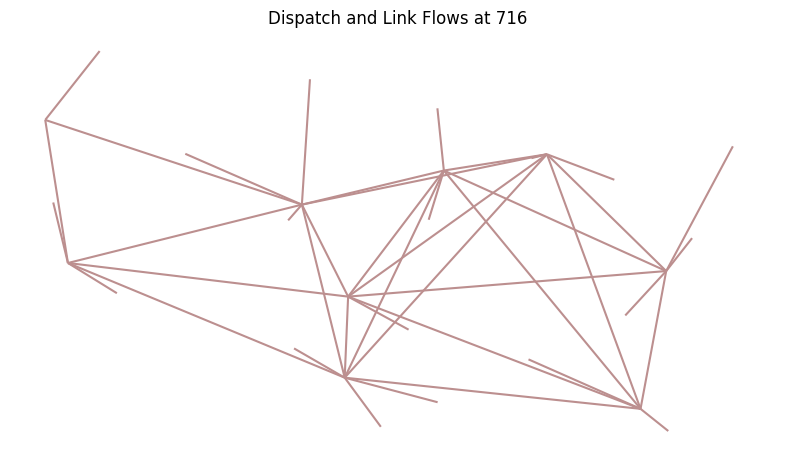

In [56]:
ph.plot_network(n, 0)
ph.plot_network(n, 44)
ph.plot_network(n, 89)
ph.plot_network(n, 134)
ph.plot_network(n, 179)

ph.line_efficiency_metrics(n, snapshot=44)[1]

In [75]:

df_elec_favored=[]
for RTE in RTEs:
    alpha, n = ph.search_min_supplyscale_bisection(
                    build_network_fn=ph.build_network,
                    distribution_nodes=distrib_nodes,
                    load_nodes=demand_nodes,
                    alpha_low=5,      # something you suspect is too small
                    alpha_high=6.3,     # you know this works
                    tol=0.1,
                    max_iter=30,
                    verbose=True,
                    build_kwargs=dict(
                        plotbool=False,           # turn off plotting during search
                        link_radius2=4000000,
                        electric_line_loss_decay=3e-5,
                        fuel_line_loss_decay=2e-5,
                        electrolysis_efficiency=np.sqrt(RTE),
                        combustion_efficiency=np.sqrt(RTE),
                        time_varying=True,
                        num_days=30,
                    ),
                )
    print("Best alpha: ", alpha)
    
    df_elec_favored.append({
        'network':n,
        'RTE':RTE,        
        'electric_decay':3e-5,
        'fuel_decay':2e-5,
        'alpha':alpha,
        'fuel-km pct': ph.fuel_km_metrics(n)[1],
        'shortest-fuel-line': ph.min_fuel_transmission_distance(n)
    })
df_elec_favored=pd.DataFrame(df_elec_favored)
                    

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 392.77it/s]
INFO:linopy.io: Writing time: 0.18s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.77e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 402.74it/s]
INFO:linopy.io: Writing time: 0.18s
Status: warning
Termination condition: infeasible
Solution: 

Minimum feasible supplyscale α* ≈ 5.8937
Best alpha:  5.89375


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 268.87it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.69e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 253.80it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.6500
Best alpha:  5.65


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 214.16it/s]
INFO:linopy.io: Writing time: 0.18s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.62e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 407.21it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.4062
Best alpha:  5.40625


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 379.21it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.61e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 402.80it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.4062
Best alpha:  5.40625


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 406.83it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.60e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 295.57it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.3250
Best alpha:  5.325


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 404.13it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.59e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 391.33it/s]
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.3250
Best alpha:  5.325


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 237.12it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.58e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 291.82it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.2438
Best alpha:  5.24375


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 721.85it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.57e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 1585.60it/s]
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.constants: Optimization successful: 
Status: ok

Minimum feasible supplyscale α* ≈ 5.2438
Best alpha:  5.24375


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 400.91it/s]
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.56e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 338.36it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.1625
Best alpha:  5.1625


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 256.01it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.55e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 393.19it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.1625
Best alpha:  5.1625


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 255.74it/s]
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.54e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 315.85it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.0812
Best alpha:  5.08125


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 288.09it/s]
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.53e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 397.39it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.0812
Best alpha:  5.08125


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 300.66it/s]
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34920 primals, 76680 duals
Objective: 1.51e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 412.76it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok


Minimum feasible supplyscale α* ≈ 5.0812
Best alpha:  5.08125


In [76]:
df_fuel_favored_static=[]

for RTE in RTEs:
    alpha, n = ph.search_min_supplyscale_bisection(
                    build_network_fn=ph.build_network,
                    distribution_nodes=distrib_nodes,
                    load_nodes=demand_nodes,
                    alpha_low=2.5,      # something you suspect is too small
                    alpha_high=2.8,     # you know this works
                    tol=0.1,
                    max_iter=30,
                    verbose=True,
                    build_kwargs=dict(
                        plotbool=False,           # turn off plotting during search
                        link_radius2=4000000,
                        electric_line_loss_decay=1e-4,
                        fuel_line_loss_decay=5e-6,
                        electrolysis_efficiency=np.sqrt(RTE),
                        combustion_efficiency=np.sqrt(RTE),
                        time_varying=False,
                    ),
                )
    print("Best alpha: ", alpha)
    
    df_fuel_favored_static.append({
        'network':n,
        'RTE':RTE, 
        'alpha':alpha,
        'electric_decay':1e-4,
        'fuel_decay':5e-6,
        'fuel-km pct': ph.fuel_km_metrics(n)[1],
        'shortest-fuel-line': ph.min_fuel_transmission_distance(n)
    })
df_fuel_favored_static=pd.DataFrame(df_fuel_favored_static)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.08e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.06e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 9.01e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termi

Minimum feasible supplyscale α* ≈ 2.7250
Best alpha:  2.7249999999999996


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.95e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.97e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.6500
Best alpha:  2.65


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.88e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.89e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.6500
Best alpha:  2.65


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.74e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.75e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.59e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.59e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


In [77]:
df_elec_favored_static=[]

for RTE in RTEs:
    alpha, n = ph.search_min_supplyscale_bisection(
                    build_network_fn=ph.build_network,
                    distribution_nodes=distrib_nodes,
                    load_nodes=demand_nodes,
                    alpha_low=2.5,      # something you suspect is too small
                    alpha_high=2.8,     # you know this works
                    tol=0.1,
                    max_iter=30,
                    verbose=True,
                    build_kwargs=dict(
                        plotbool=False,           # turn off plotting during search
                        link_radius2=4000000,
                        electric_line_loss_decay=3e-5,
                        fuel_line_loss_decay=2e-5,
                        electrolysis_efficiency=np.sqrt(RTE),
                        combustion_efficiency=np.sqrt(RTE),
                        time_varying=False,
                    ),
                )
    print("Best alpha: ", alpha)
    
    df_elec_favored_static.append({
        'network':n,
        'alpha':alpha,
        'RTE':RTE, 
        'electric_decay':3e-5,
        'fuel_decay':2e-5,
        'fuel-km pct': ph.fuel_km_metrics(n)[1],
        'shortest-fuel-line': ph.min_fuel_transmission_distance(n)
    })
df_elec_favored_static=pd.DataFrame(df_elec_favored_static)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.42e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.43e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.40e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 176 primals, 408 duals
Objective: 8.41e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were

Minimum feasible supplyscale α* ≈ 2.5750
Best alpha:  2.575


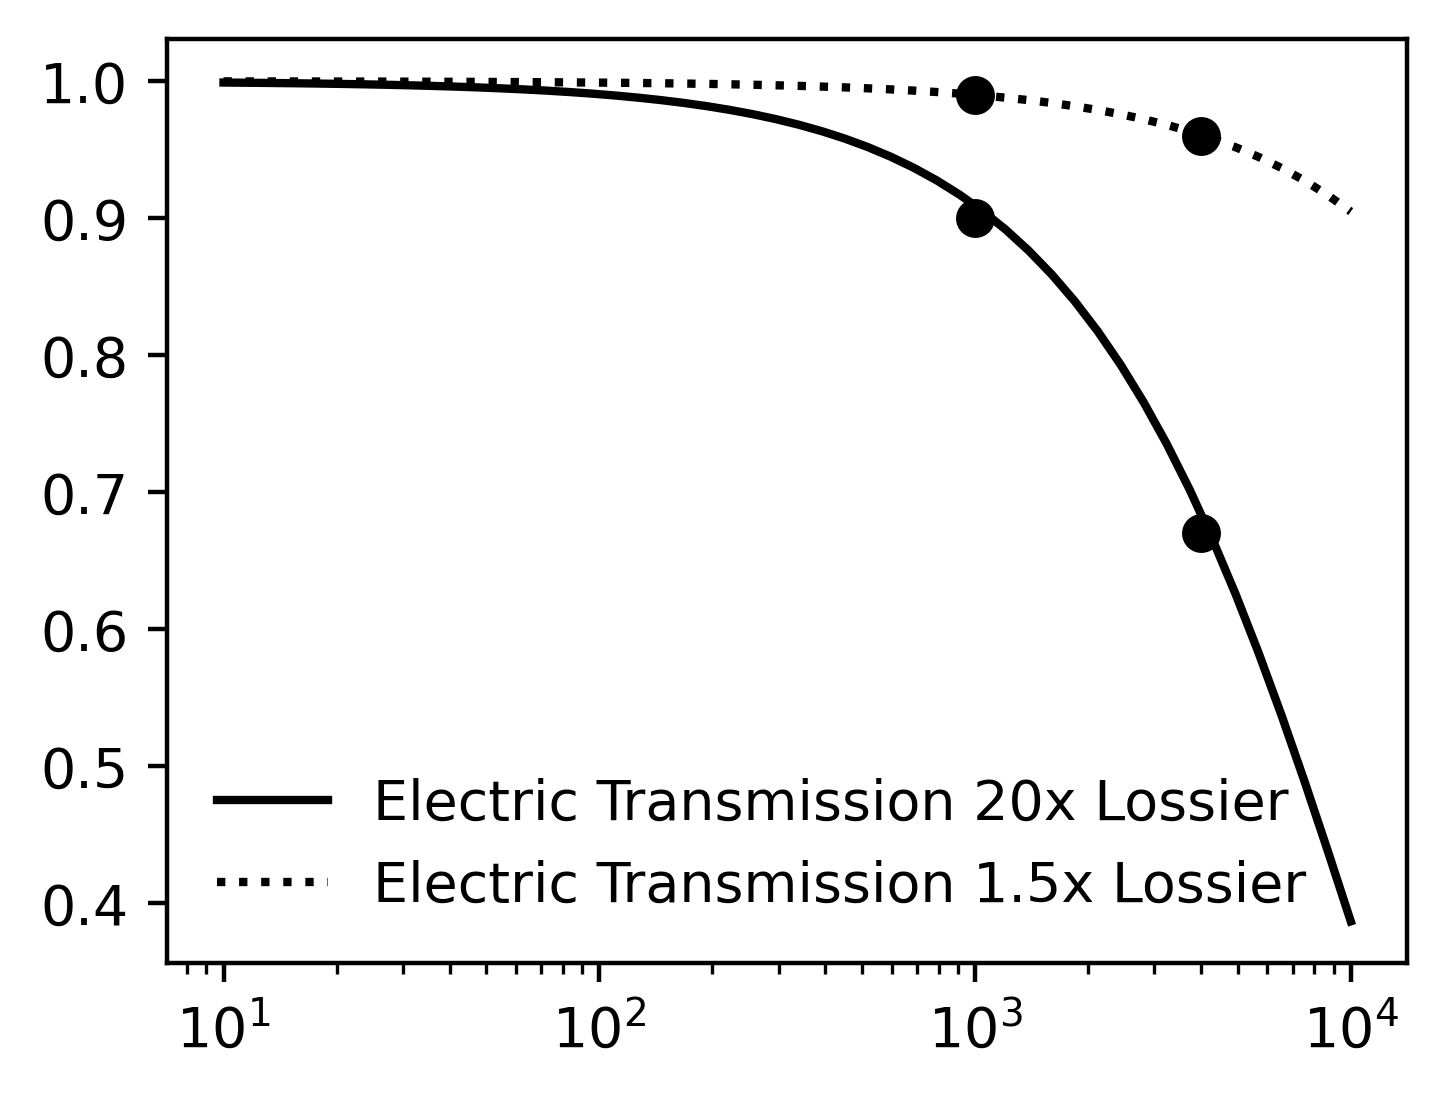

In [114]:
alpha_e_min = 3e-5
alpha_e_max = 1e-4

alpha_c_min = 5e-6
alpha_c_max = 2e-5

eta_ce_biggest = 0.46
eta_ce_medium = 0.38
eta_ce_smallest = 0.22
distances = np.logspace(1, 4)

electric_favored_ratio = (1-alpha_e_min)/(1-alpha_c_max)
fuel_favored_ratio = (1-alpha_e_max)/(1-alpha_c_min)

plt.figure(figsize=(4, 3), dpi=400)
plt.plot(distances, np.exp(distances*np.log(fuel_favored_ratio)), label="Electric Transmission 20x Lossier", color="black")
plt.plot(distances, np.exp(distances*np.log(electric_favored_ratio)), label="Electric Transmission 1.5x Lossier", color="black", linestyle=":")
plt.scatter(1000, 0.9, color='black')
plt.scatter(1000, 0.99, color='black')

plt.scatter(4000, 0.67, color='black')
plt.scatter(4000, 0.96, color='black')

plt.legend( frameon=False)
#plt.scatter(df_elec_favored_static["shortest-fuel-line"], RTEs, color="#26A3BA", facecolor = "white", zorder=10)
#plt.scatter(df_fuel_favored_static["shortest-fuel-line"], RTEs, color = "#26A3BA", zorder=10)
#plt.scatter(df_elec_favored["shortest-fuel-line"], RTEs, color = "#E60027")
#plt.scatter(df_fuel_favored["shortest-fuel-line"], RTEs, color = "#E60027")

plt.xscale('log')

In [84]:
df_elec_favored["Storage"] = True
df_fuel_favored["Storage"] = True
df_elec_favored_static["Storage"] = False
df_fuel_favored_static["Storage"] = False
total_df=pd.concat([df_elec_favored_static, df_fuel_favored_static,df_elec_favored,df_fuel_favored  ], ignore_index=True)
total_df.drop(columns='network').to_excel("results_df.xlsx", index=False)

In [88]:
#total_df = pd.read_excel("results_df.xlsx")
#total_df=pd.concat([total_df, df_elec_favored_static, df_fuel_favored_static,df_elec_favored,df_fuel_favored  ], ignore_index=True)
total_df.head()

,network,alpha,RTE,electric_decay,fuel_decay,fuel-km pct,shortest-fuel-line,Storage,hue_pair
0,PyPSA Network 'Unnamed Network',2.575,0.500,0.00003,0.00002,0.0,NaN,False,2e-05_False
1,PyPSA Network 'Unnamed Network',2.575,0.600,0.00003,0.00002,0.0,NaN,False,2e-05_False
2,PyPSA Network 'Unnamed Network',2.575,0.700,0.00003,0.00002,0.0,NaN,False,2e-05_False
3,PyPSA Network 'Unnamed Network',2.575,0.725,0.00003,0.00002,0.0,NaN,False,2e-05_False
4,PyPSA Network 'Unnamed Network',2.575,0.750,0.00003,0.00002,0.0,NaN,False,2e-05_False


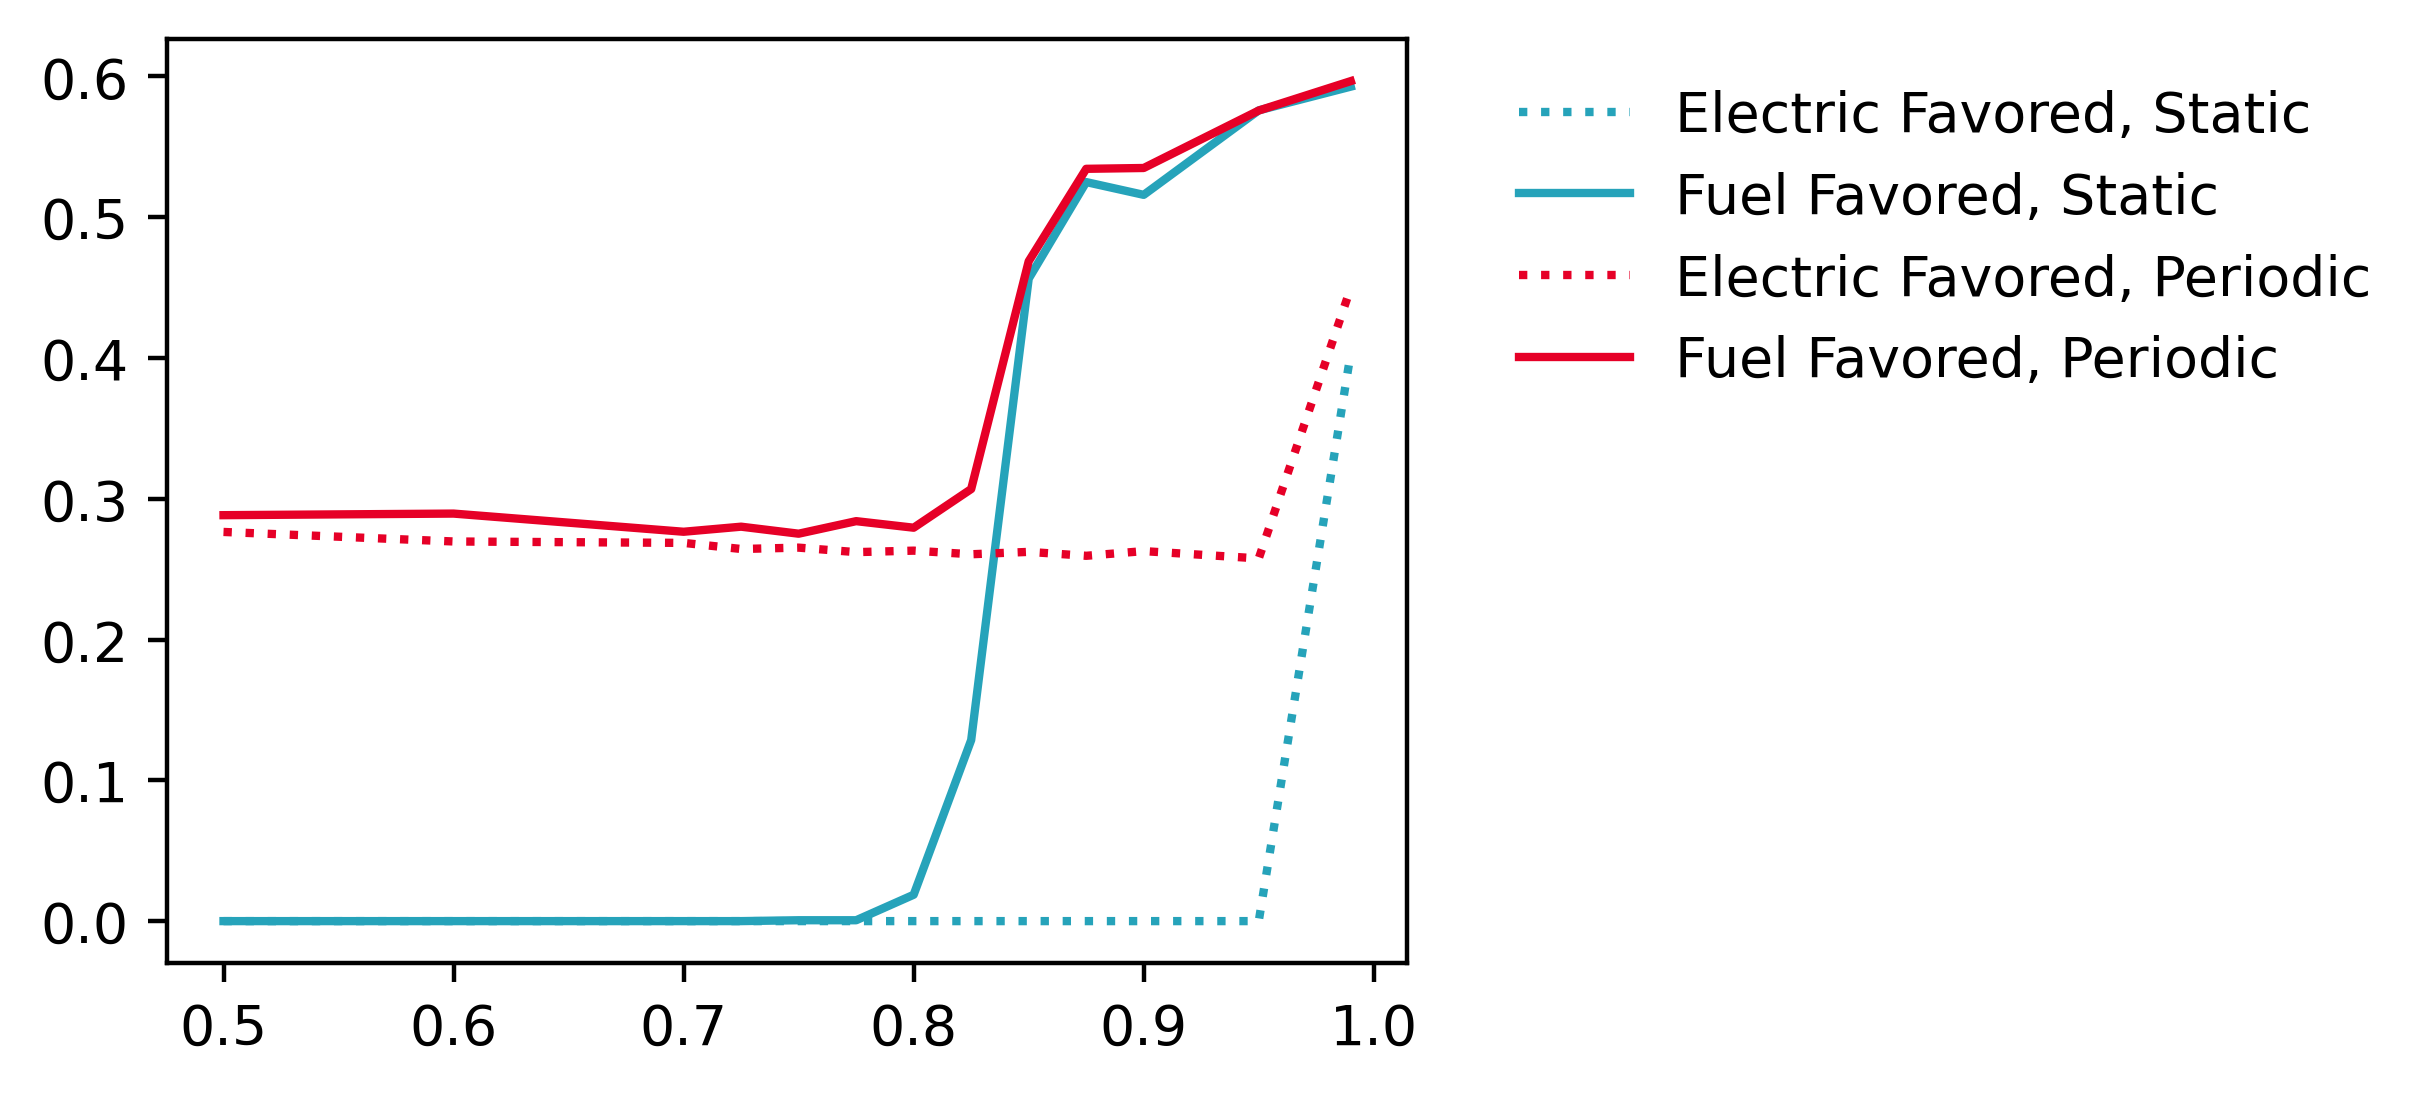

In [100]:
plt.figure(figsize=(4, 3), dpi=400)
total_df["hue_pair"] = total_df["fuel_decay"].astype(str) + "_" + total_df["Storage"].astype(str)

plt.plot(total_df[total_df["hue_pair"]=="2e-05_False"]['RTE'],
         total_df[total_df["hue_pair"]=="2e-05_False"]['fuel-km pct'],
         label="Electric Favored, Static",
         linestyle = ":",
         color='#26A3BA')

plt.plot(total_df[total_df["hue_pair"]=="5e-06_False"]['RTE'],
         total_df[total_df["hue_pair"]=="5e-06_False"]['fuel-km pct'],
         label="Fuel Favored, Static",
         color='#26A3BA')

plt.plot(total_df[total_df["hue_pair"]=="2e-05_True"]['RTE'],
         total_df[total_df["hue_pair"]=="2e-05_True"]['fuel-km pct'],
         label="Electric Favored, Periodic",
         linestyle = ":",
         color='#E60027')
plt.plot(total_df[total_df["hue_pair"]=="5e-06_True"]['RTE'],
         total_df[total_df["hue_pair"]=="5e-06_True"]['fuel-km pct'],
         label="Fuel Favored, Periodic",
         color='#E60027')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


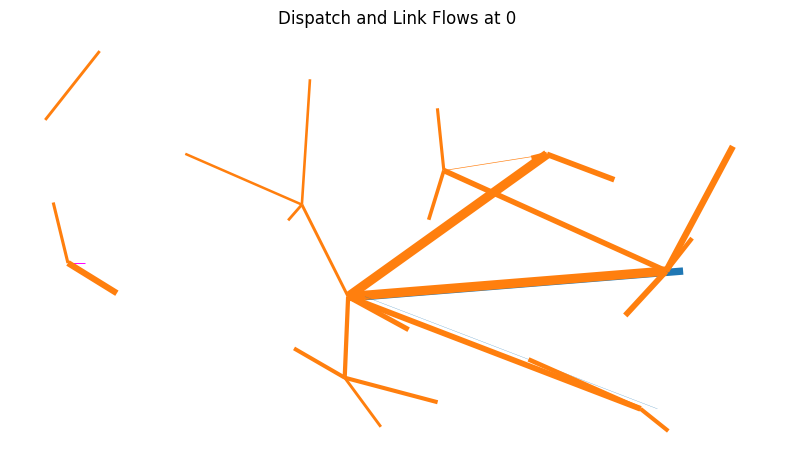

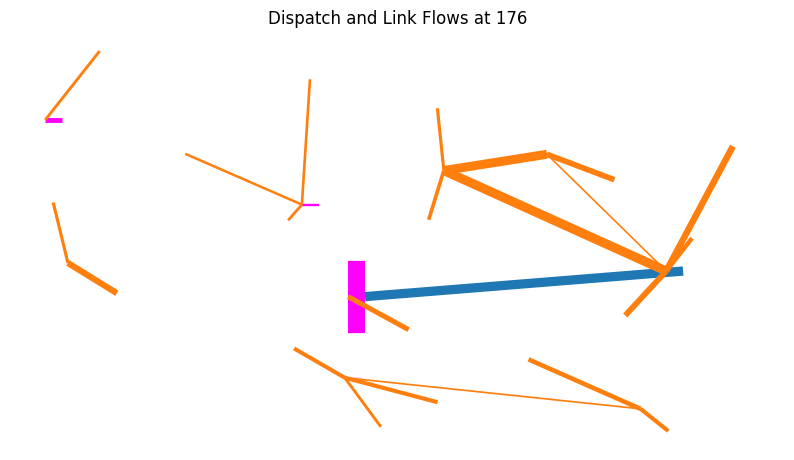

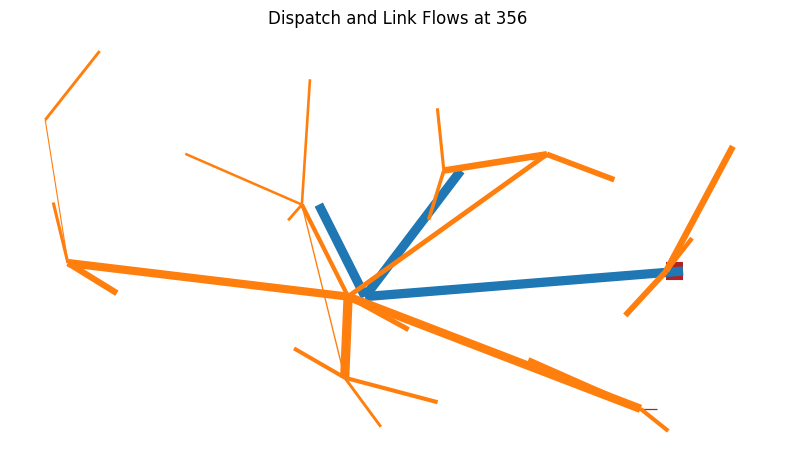

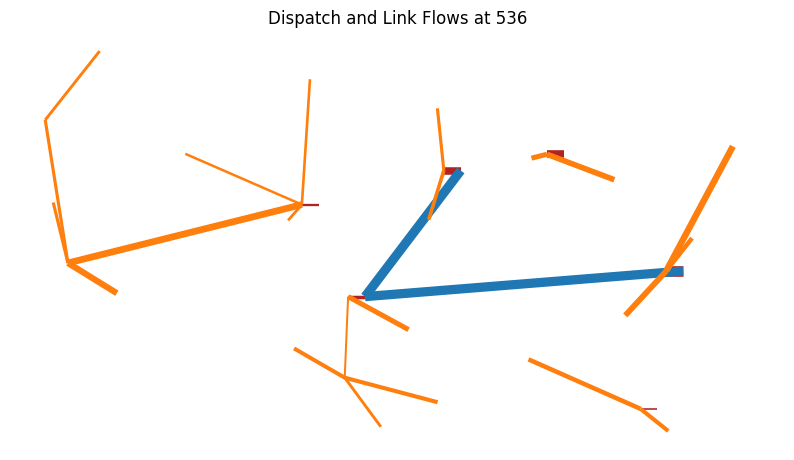

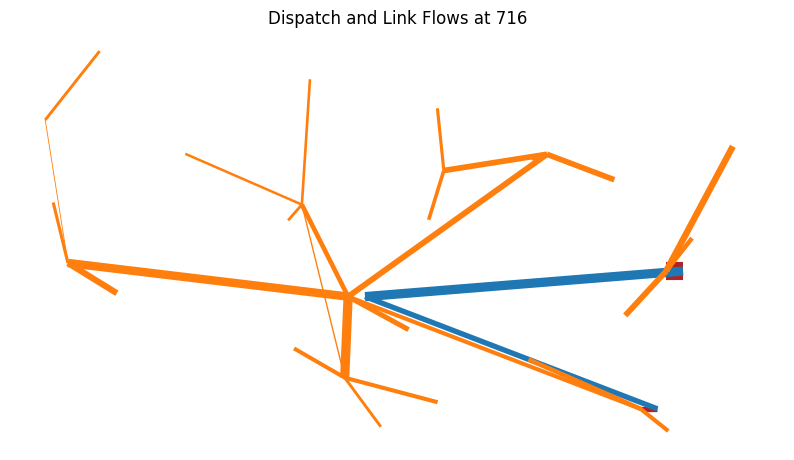

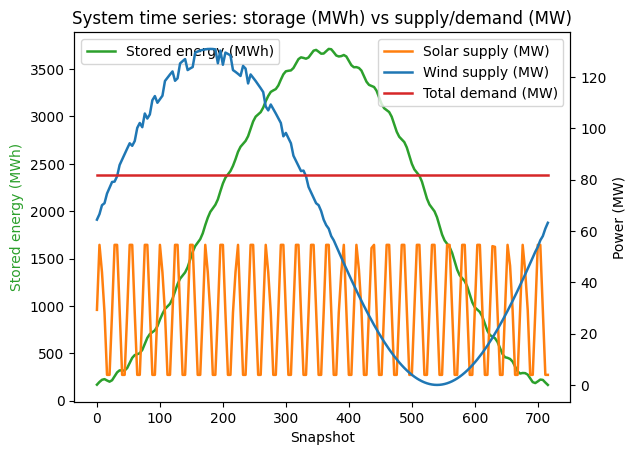

In [129]:
ph.plot_network(total_df.iloc[45]["network"],0)
ph.plot_network(total_df.iloc[45]["network"],44)
ph.plot_network(total_df.iloc[45]["network"],89)
ph.plot_network(total_df.iloc[45]["network"],134)
ph.plot_network(total_df.iloc[45]["network"],179)
ph.plot_system_timeseries_dualaxis(total_df.iloc[45]["network"])


In [116]:
total_df

,network,alpha,RTE,electric_decay,fuel_decay,fuel-km pct,shortest-fuel-line,Storage,hue_pair
0,PyPSA Network 'Unnamed Network',2.57500,0.500,0.00003,0.000020,0.000000,NaN,False,2e-05_False
1,PyPSA Network 'Unnamed Network',2.57500,0.600,0.00003,0.000020,0.000000,NaN,False,2e-05_False
2,PyPSA Network 'Unnamed Network',2.57500,0.700,0.00003,0.000020,0.000000,NaN,False,2e-05_False
3,PyPSA Network 'Unnamed Network',2.57500,0.725,0.00003,0.000020,0.000000,NaN,False,2e-05_False
4,PyPSA Network 'Unnamed Network',2.57500,0.750,0.00003,0.000020,0.000000,NaN,False,2e-05_False
5,PyPSA Network 'Unnamed Network',2.57500,0.775,0.00003,0.000020,0.000000,NaN,False,2e-05_False
6,PyPSA Network 'Unnamed Network',2.57500,0.800,0.00003,0.000020,0.000000,NaN,False,2e-05_False
7,PyPSA Network 'Unnamed Network',2.57500,0.825,0.00003,0.000020,0.000000,NaN,False,2e-05_False
8,PyPSA Network 'Unnamed Network',2.57500,0.850,0.00003,0.000020,0.000000,NaN,False,2e-05_False
9,PyPSA Network 'Unnamed Network',2.57500,0.875,0.00003,0.000020,0.000000,NaN,False,2e-05_False
